In [1]:

import plotly.express as px
import pandas as pd
import json
import os
os.environ['USER'] = "rmoine"
from pathlib import Path
import numpy as np
import re
from typing import *
from llama.main import compute_metrics_from_files, DatasetName, compute_metrics_from_list, get_tokenizer, plot_confusion
import llama.main as m
from sklearn.metrics import f1_score, auc, roc_curve
from PIL import Image
from pandasql import sqldf
from io import BytesIO
import base64
from plotly.graph_objects import Figure
import win32clipboard
import textwrap
import colorsys
import optuna
import tqdm
def img_to_clipboard(fig: Figure):
    img_bytes = fig.to_image(format="png")
    image = Image.open(BytesIO(img_bytes))
    
    output = BytesIO()
    image.convert('RGB').save(output, 'BMP')
    data = output.getvalue()[14:]
    output.close()
    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardData(win32clipboard.CF_DIB, data)
    win32clipboard.CloseClipboard()
folder_name = "inference"
root = Path(f"../../data/{folder_name}/")

c:\Users\robin\miniconda3\envs\severityPrediction\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Import of import evaluate failed
Import of from pytorchtools import EarlyStopping failed


In [10]:
split = {}
split_per_type = {}
for dataset_choice in ["eclipse_72k","mozilla_200k"]:
    with open(f"../../data/split_{dataset_choice}.json") as fp:
        split_per_type[dataset_choice] = json.load(fp)
        split[dataset_choice] = {}
        for dataset_type, bug_ids in split_per_type[dataset_choice].items():
            for bug_id in bug_ids:
                split[dataset_choice][bug_id] = dataset_type

In [21]:

l = []
tokenizer = get_tokenizer(m.default_token, m.default_model)
pathes = list(root.rglob("inference__*"))
for path_data in tqdm.tqdm(pathes):
    with open(path_data / "parameters.json") as fp:
        parameters = json.load(fp)
    dataset_choice = parameters["dataset_choice"]
    files_data = list(path_data.rglob(f"predictions_*.json"))
    if len(files_data) == 0:
        continue
    for f in files_data:
        d = []
        with open(f) as fp:
            for line in fp.readlines():
                if line.strip() == '':
                    continue
                try:
                    line = json.loads(line)
                except Exception as e:
                    print(e)
                    print(line)
                    raise Exception
                l.append({
                    **line,
                    "dataset_type": split[dataset_choice][line['bug_id']],
                    "dataset_choice":dataset_choice,
                    "parameters":{**parameters,"path_data_folder": path_data.stem}, 
                    "prompt_id": parameters['prompt_id']}
                )
dfs = pd.DataFrame(l)
    


100%|██████████| 300/300 [12:45<00:00,  2.55s/it]   


In [20]:
list(dfs['alpaca'])

['input',
 'n_tokens',
 'tokenized',
 'bug_id',
 'bug_severity',
 'binary_severity',
 'stemmed_description',
 'description',
 'answer',
 'severity_pred',
 'dataset_type',
 'dataset_choice',
 'parameters']

In [22]:
dfs.to_json(root / "dfs.json")

In [20]:
dfs = pd.read_json(root / "dfs.json")

In [21]:
dfs.columns

Index(['input', 'n_tokens', 'tokenized', 'bug_id', 'bug_severity',
       'binary_severity', 'stemmed_description', 'description', 'answer',
       'severity_pred', 'dataset_type', 'dataset_choice', 'parameters',
       'prompt_id'],
      dtype='object')

In [25]:
missing_bug_id_in_df = {}
ref_severities = {}
datasets = {}
for d in ["eclipse_72k","mozilla_200k"]:
    with open(root / f"../llm/{d}.json") as fp:
        datasets[d] = json.load(fp)
df_preprocessed = dfs.copy()
for (dataset_choice, dataset_type, prompt_id), group in dfs.drop_duplicates(subset=["dataset_choice", "dataset_type", "prompt_id", "bug_id"]).groupby(["dataset_choice", "dataset_type", "prompt_id"]):
    print(dataset_choice, dataset_type, prompt_id)
    missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)] = set(split_per_type[dataset_choice][dataset_type]) - set(group["bug_id"].unique())
    if len(missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)]) > 0:
        if dataset_choice not in ref_severities:
            ref_severities[dataset_choice] = {}
        to_add = []
        for dico in datasets[dataset_choice]:
            if dico["bug_id"] in missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)]:
                to_add.append({
                    "dataset_choice":dataset_choice, 
                    "dataset_type":dataset_type, 
                    "prompt_id":prompt_id, 
                    "severity_pred": -2, 
                    "binary_severity": dico["binary_severity"]
                })
        df_preprocessed = pd.concat([df_preprocessed,pd.DataFrame(to_add, columns=df_preprocessed.columns)], ignore_index=True)

eclipse_72k test alpaca
eclipse_72k test official
eclipse_72k tr alpaca
eclipse_72k tr official
eclipse_72k val alpaca
eclipse_72k val official
mozilla_200k test alpaca
mozilla_200k test official
mozilla_200k tr alpaca
mozilla_200k tr official
mozilla_200k val alpaca
mozilla_200k val official


In [6]:
df_preprocessed = dfs.drop_duplicates(subset=["prompt_id","dataset_choice","bug_id"]).groupby(["dataset_choice","dataset_type","bug_id"]).filter(lambda x:len(x)==2)

In [7]:
groups = df_preprocessed.drop_duplicates(subset=["prompt_id","dataset_choice","bug_id"]).groupby(["prompt_id","dataset_choice","dataset_type"])

In [26]:
df_counts = pd.DataFrame({(dataset_choice,dataset_type): [] for dataset_choice in df_preprocessed["dataset_choice"].unique() for dataset_type in ["tr","val","test"]})
groups_no_prompt = df_preprocessed.drop_duplicates(subset=["dataset_choice","bug_id"]).groupby(["dataset_choice","dataset_type"])
for (dataset_choice, dataset_type), group_data in groups_no_prompt:
    tot_samples_dataset = sum(len(v) for v in split_per_type[dataset_choice].values())
    print(dataset_choice, dataset_type,len(group_data))
    df_counts.at["Absolute", (dataset_choice, dataset_type)] = len(group_data)
    df_counts.at["Percentage of dataset", (dataset_choice, dataset_type)] = np.round(len(group_data)/tot_samples_dataset*100,decimals=0)
df_counts = df_counts.astype(int)
display(df_counts)

eclipse_72k test 7220
eclipse_72k tr 50534
eclipse_72k val 14438
mozilla_200k test 19952
mozilla_200k tr 139651
mozilla_200k val 39901


eclipse_72k              mozilla_200k              
                               tr    val  test           tr    val   test
Absolute                    50534  14438  7220       139651  39901  19952
Percentage of dataset          70     20    10           70     20     10

severity_pred dataset_type prompt_id dataset_choice dataset_type
3              -1         test    alpaca    eclipse_72k         test
9               0         test    alpaca    eclipse_72k         test
10              0         test    alpaca    eclipse_72k         test
17              1         test    alpaca    eclipse_72k         test
38             -1         test    alpaca    eclipse_72k         test

[[ 825  705  280]
 [2502 1811 1097]]


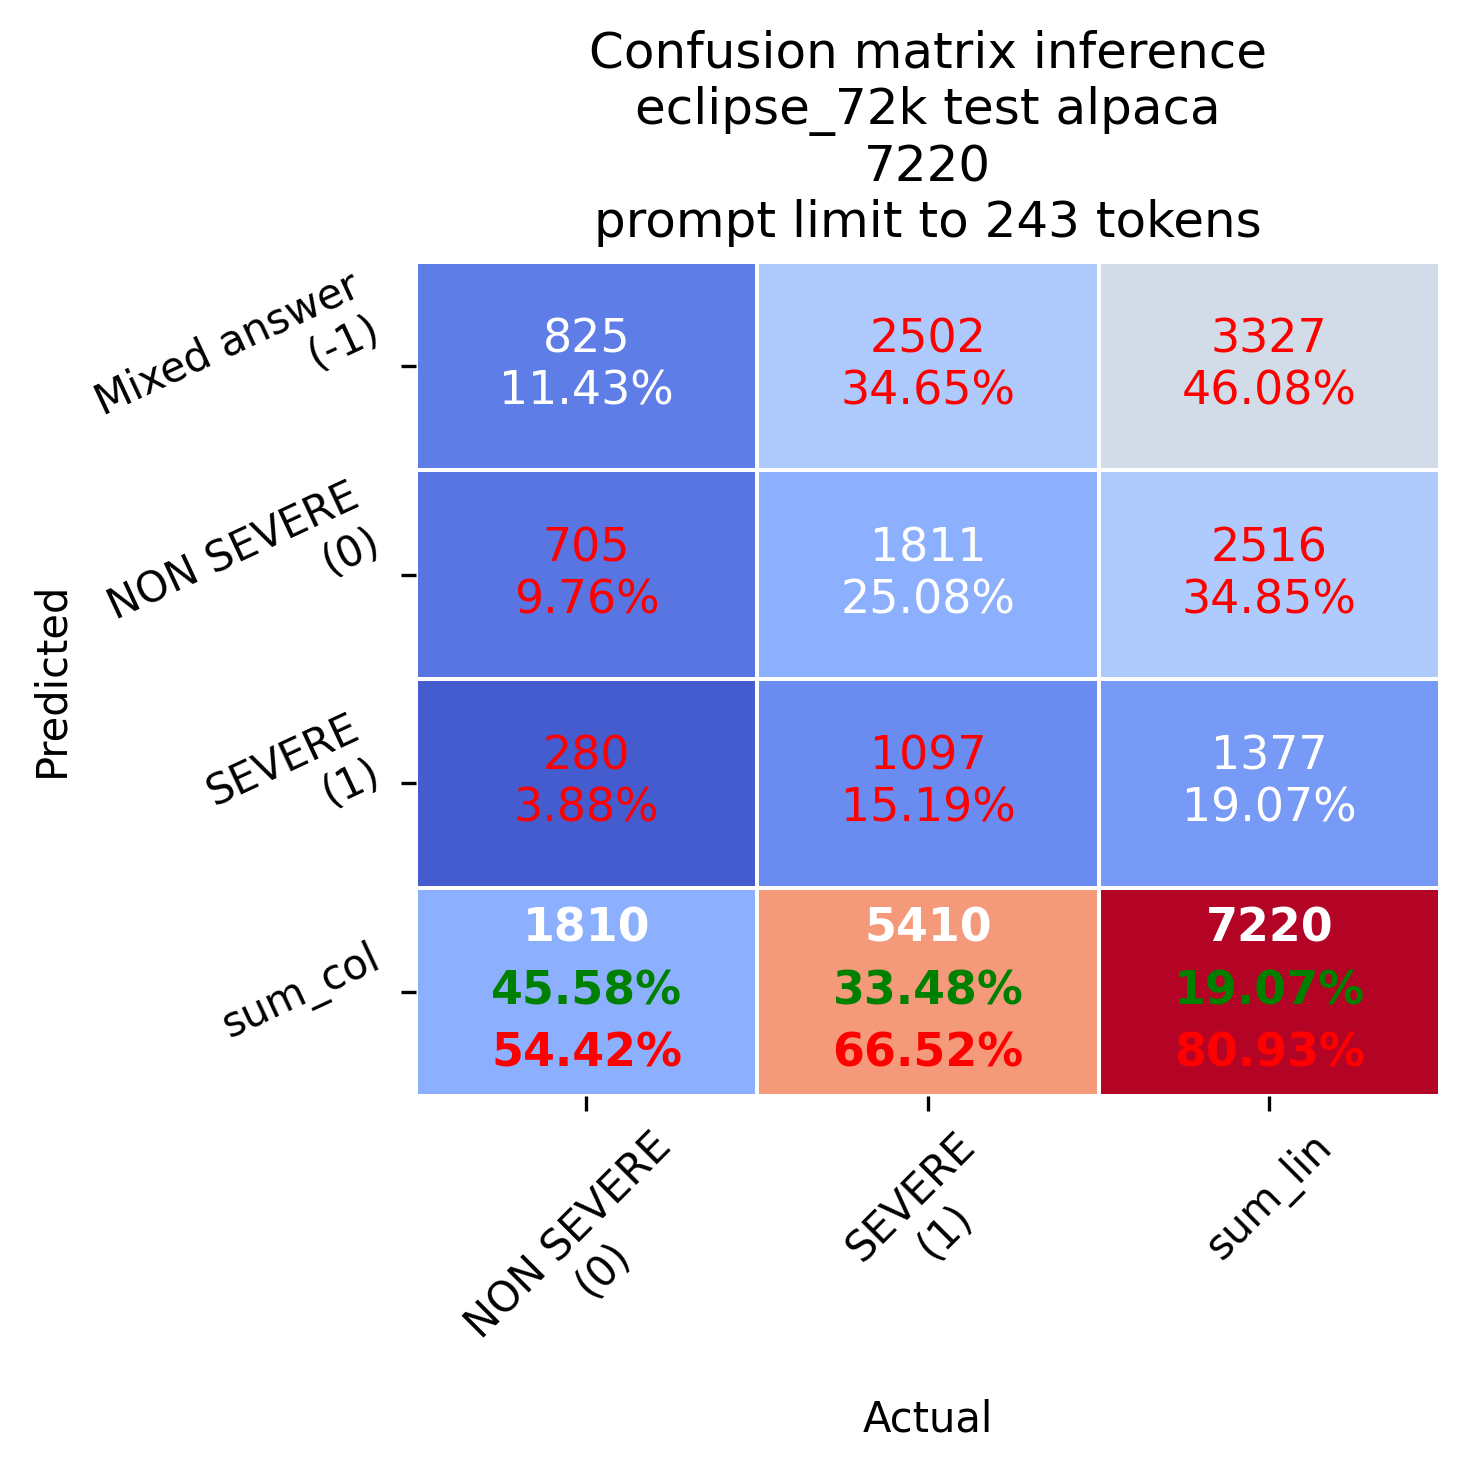

severity_pred dataset_type prompt_id dataset_choice dataset_type
0              0           tr    alpaca    eclipse_72k           tr
1             -1           tr    alpaca    eclipse_72k           tr
2             -1           tr    alpaca    eclipse_72k           tr
4             -1           tr    alpaca    eclipse_72k           tr
5             -1           tr    alpaca    eclipse_72k           tr

[[ 5597  4914  2153]
 [17828 12599  7443]]


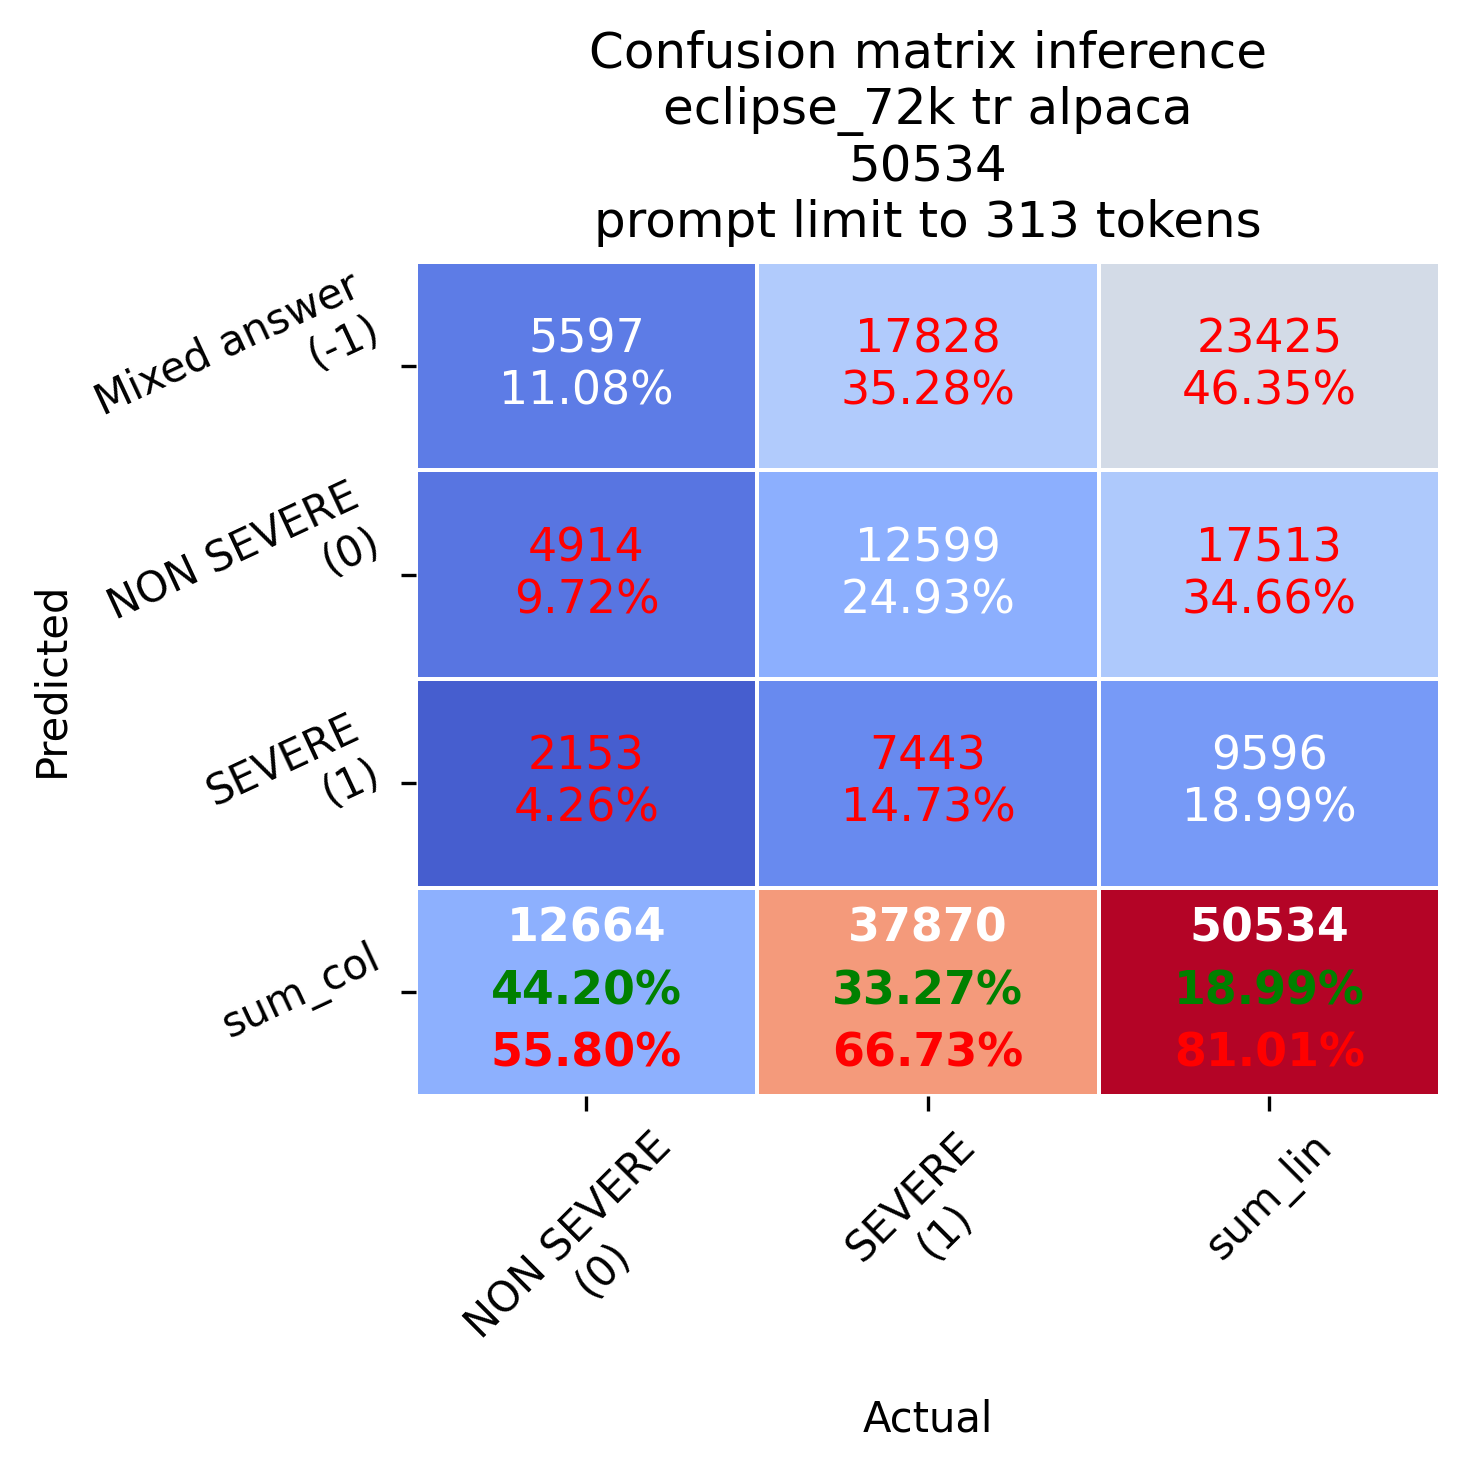

severity_pred dataset_type prompt_id dataset_choice dataset_type
7               1          val    alpaca    eclipse_72k          val
22             -1          val    alpaca    eclipse_72k          val
23             -1          val    alpaca    eclipse_72k          val
31             -1          val    alpaca    eclipse_72k          val
33             -1          val    alpaca    eclipse_72k          val

[[1580 1436  602]
 [5046 3615 2159]]


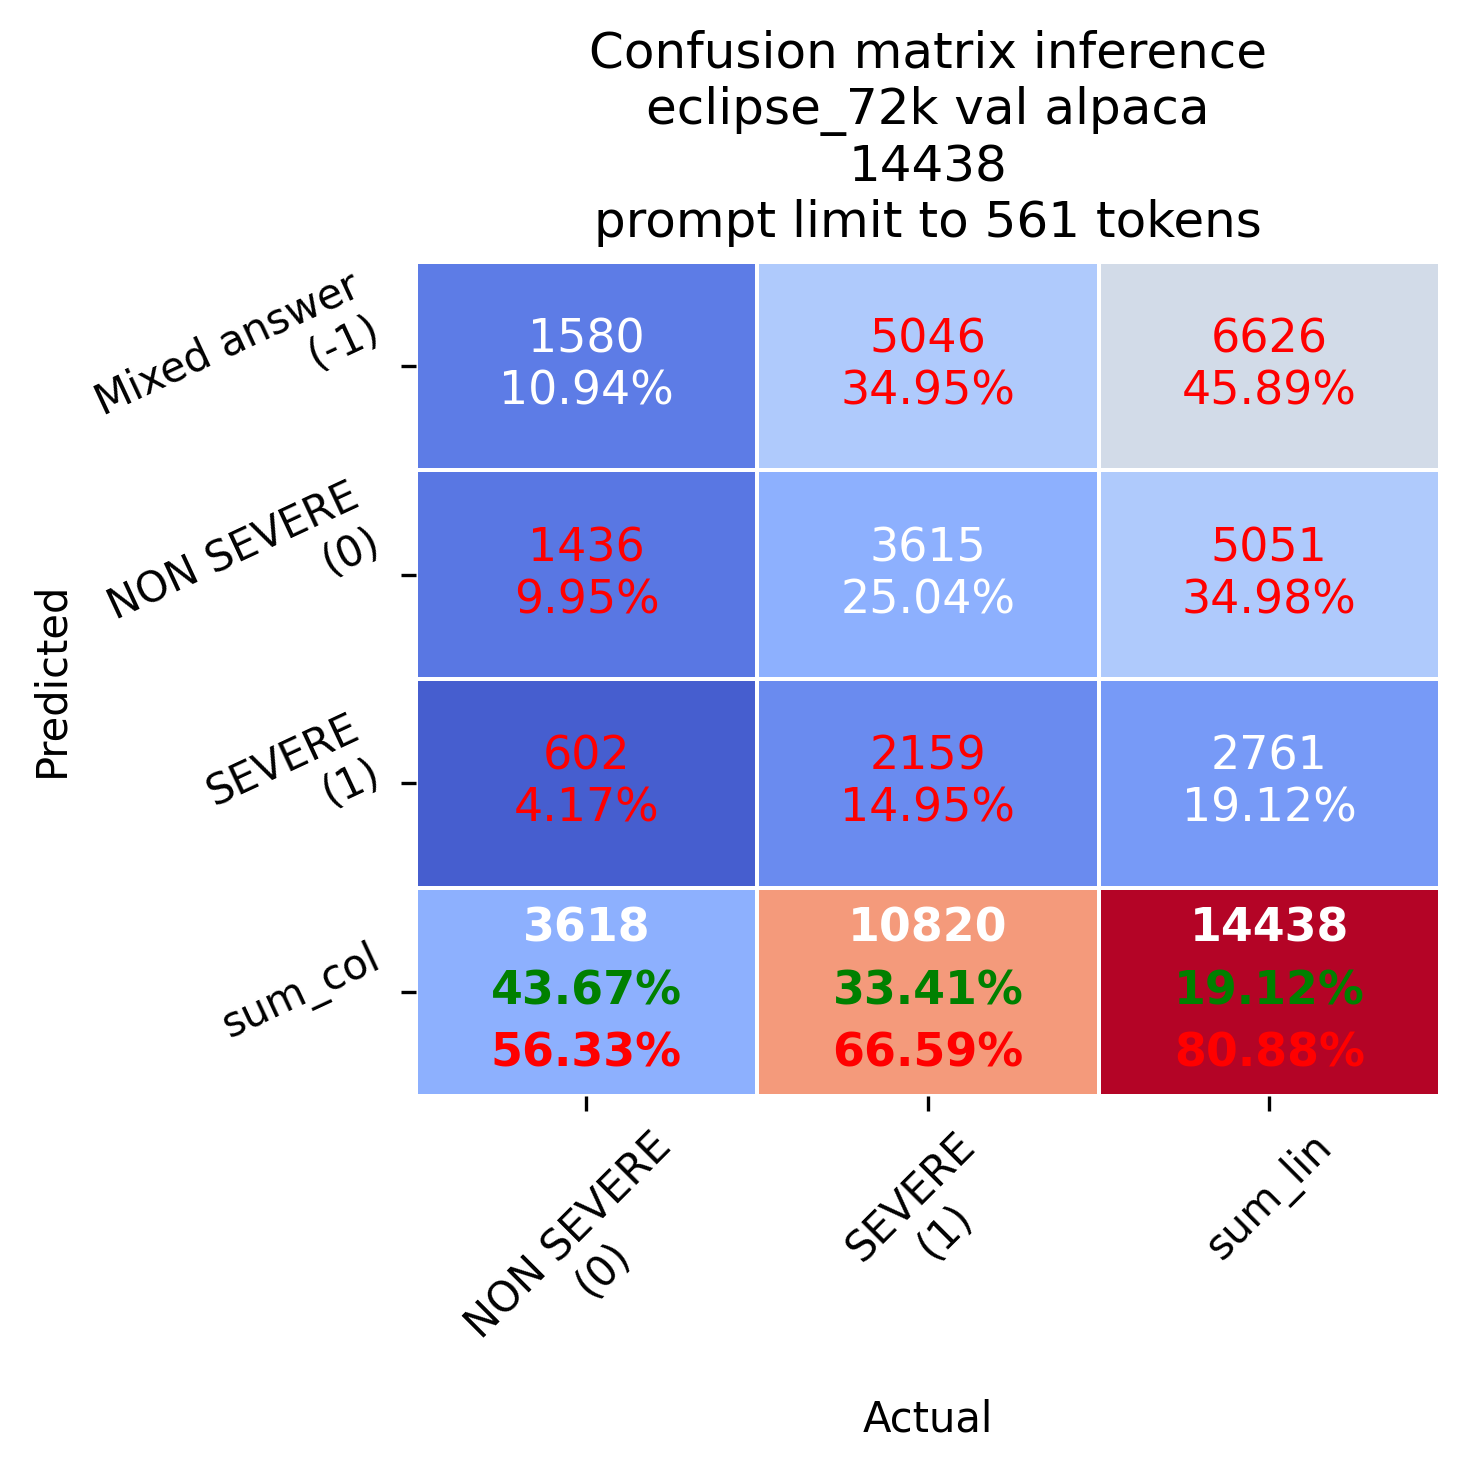

severity_pred dataset_type prompt_id dataset_choice dataset_type
288774             -1         test    alpaca   mozilla_200k         test
288796             -1         test    alpaca   mozilla_200k         test
288811             -1         test    alpaca   mozilla_200k         test
288817             -1         test    alpaca   mozilla_200k         test
288843             -1         test    alpaca   mozilla_200k         test

[[2852 1808  118]
 [8551 4664  432]]


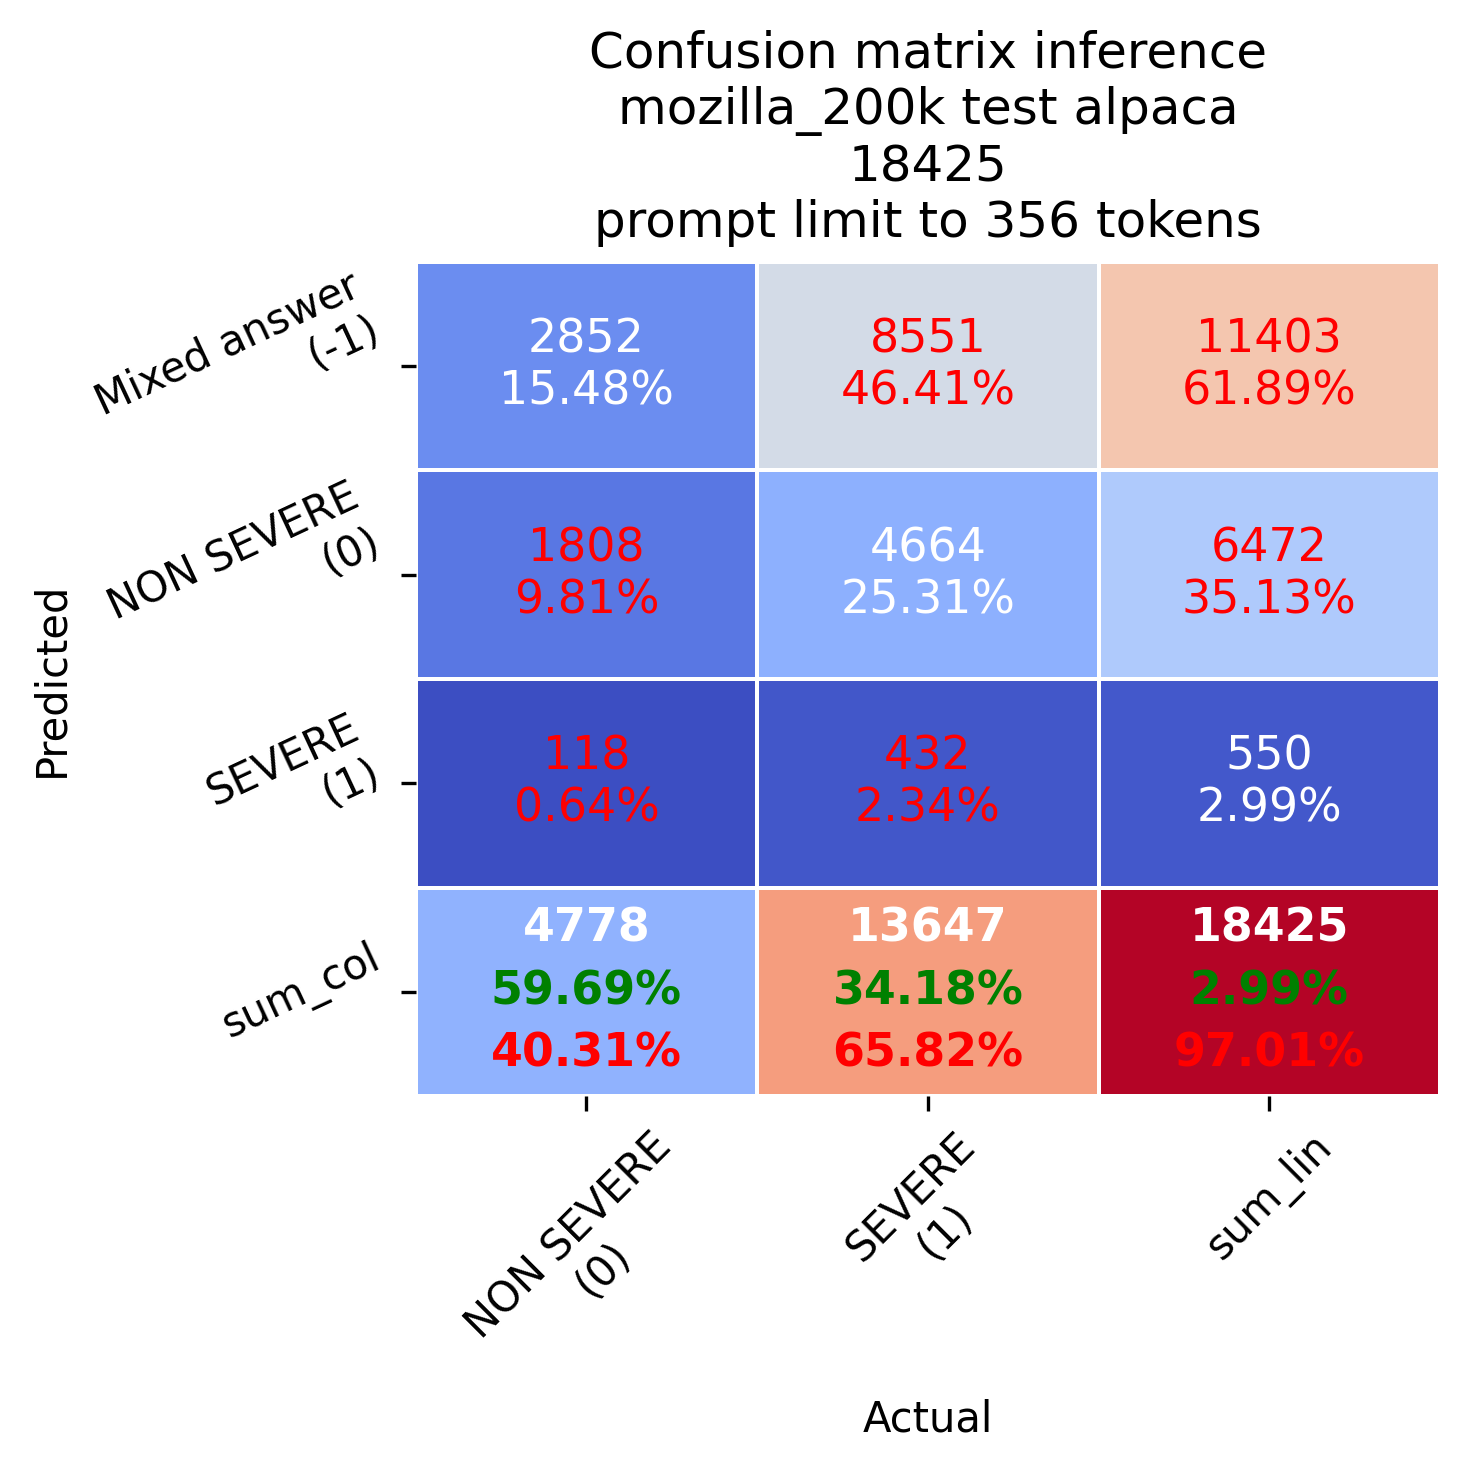

severity_pred dataset_type prompt_id dataset_choice dataset_type
288768             -1           tr    alpaca   mozilla_200k           tr
288769             -1           tr    alpaca   mozilla_200k           tr
288770             -1           tr    alpaca   mozilla_200k           tr
288772              0           tr    alpaca   mozilla_200k           tr
288773              0           tr    alpaca   mozilla_200k           tr

[[20159 12244   758]
 [59412 32793  3072]]


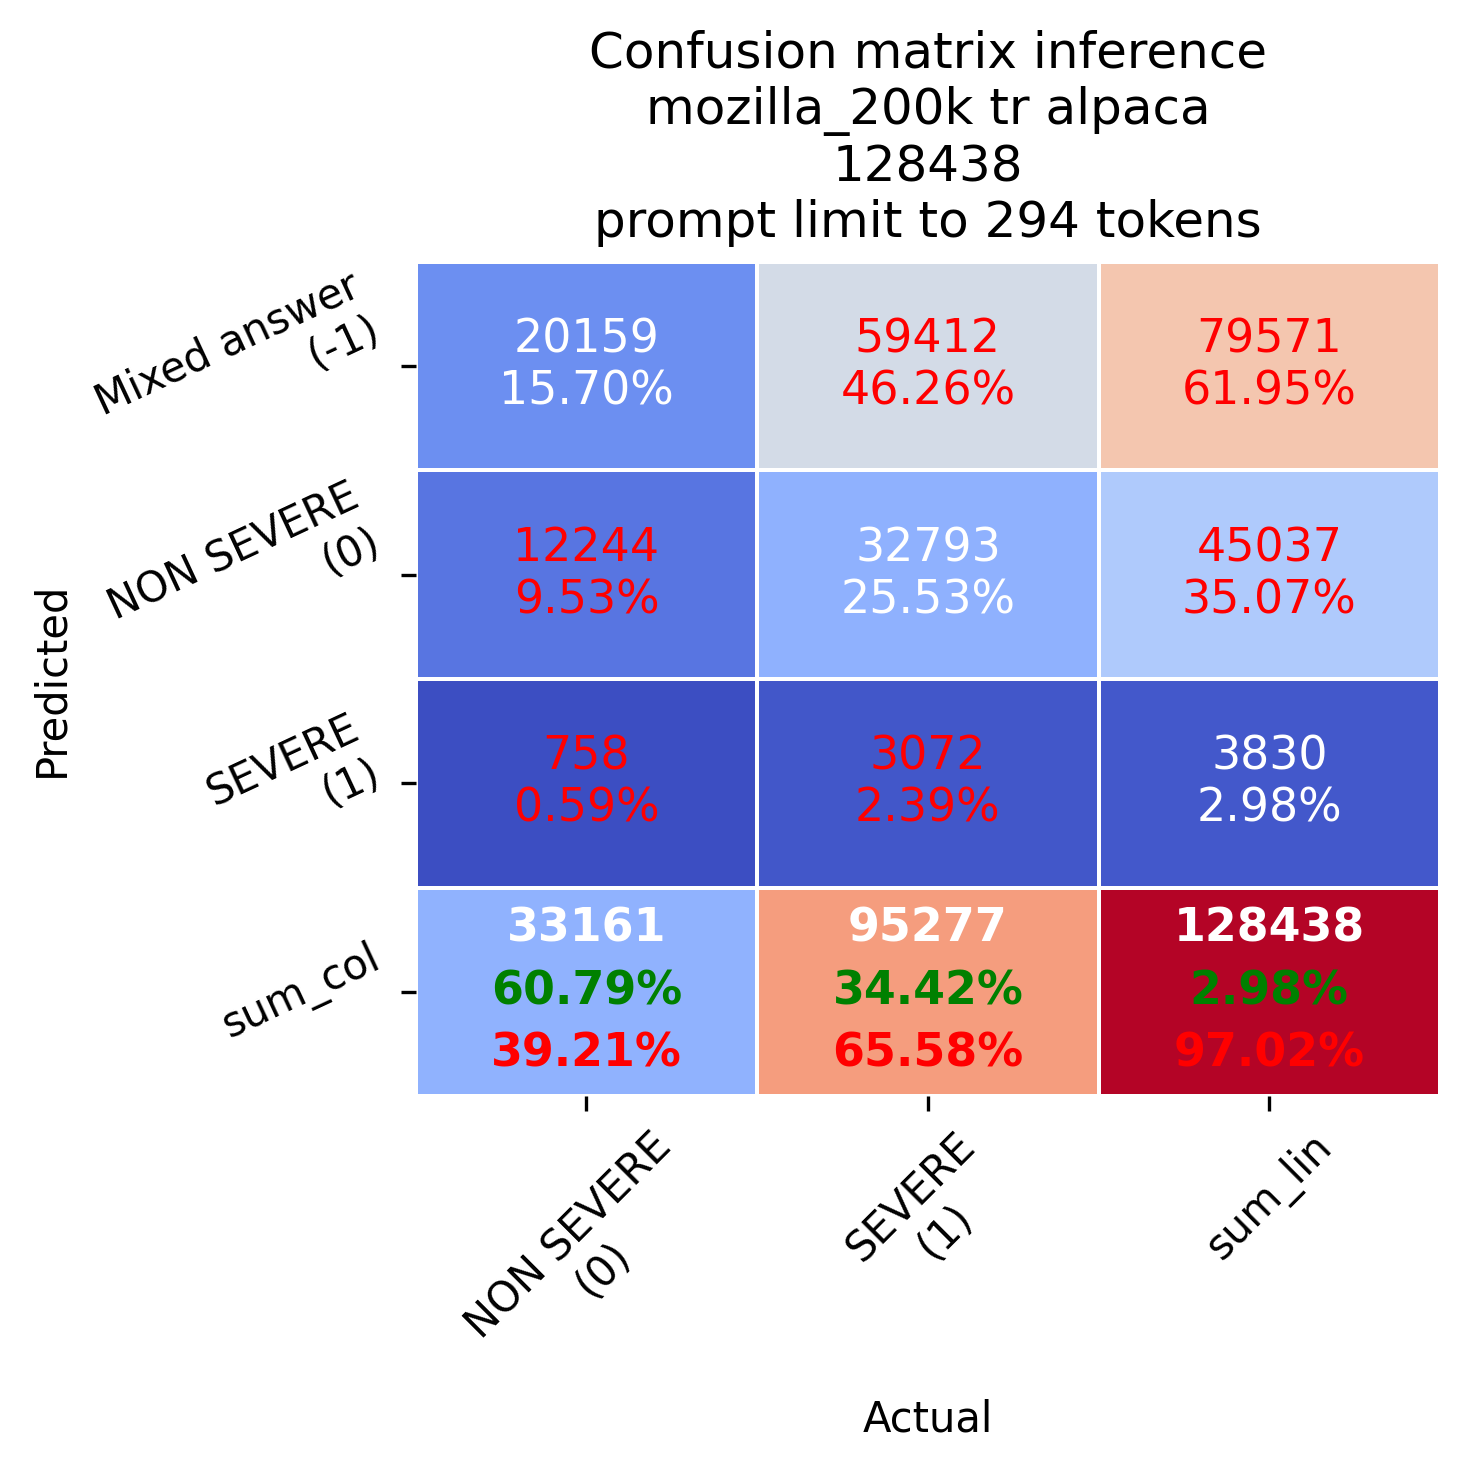

severity_pred dataset_type prompt_id dataset_choice dataset_type
288771             -1          val    alpaca   mozilla_200k          val
288777             -1          val    alpaca   mozilla_200k          val
288785             -1          val    alpaca   mozilla_200k          val
288786             -1          val    alpaca   mozilla_200k          val
288797             -1          val    alpaca   mozilla_200k          val

[[ 5802  3512   204]
 [16843  9425   894]]


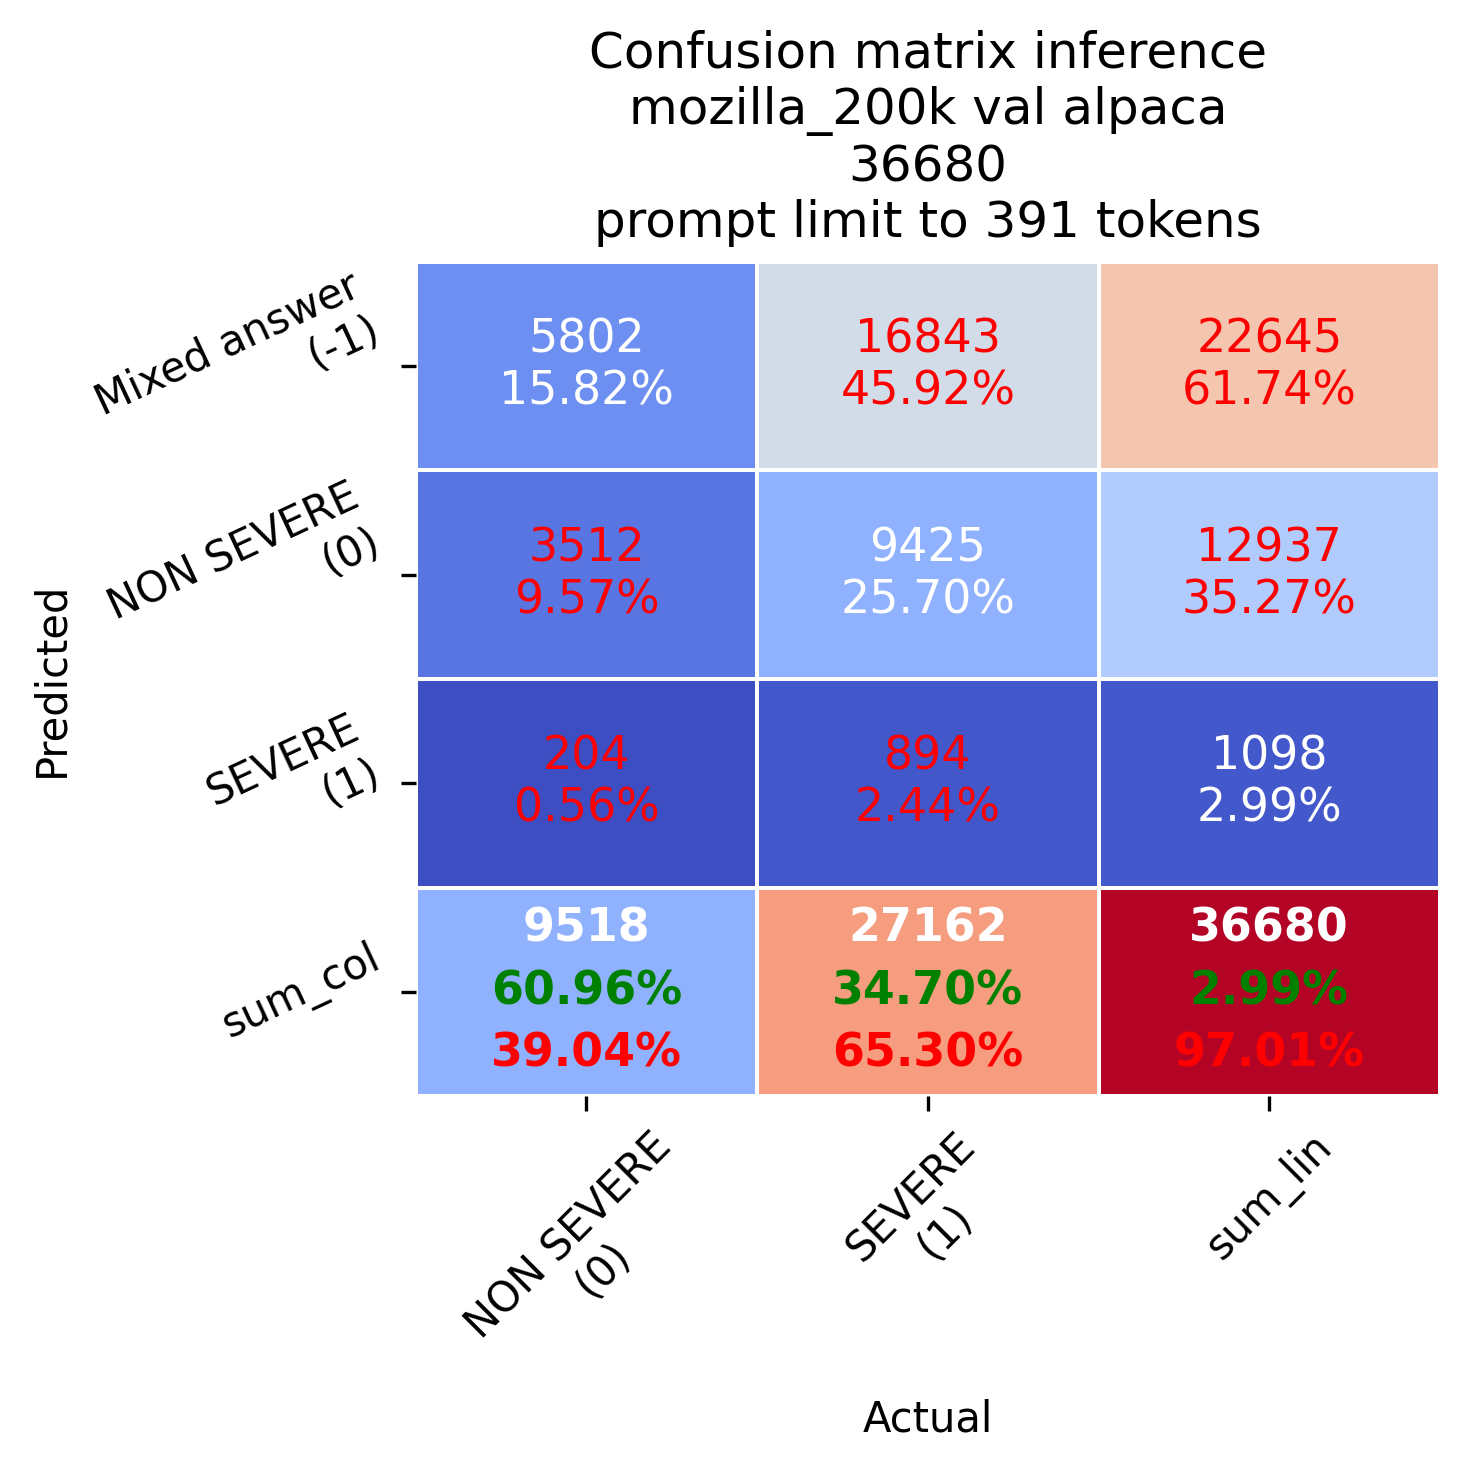

severity_pred dataset_type prompt_id dataset_choice dataset_type
72195              1         test  official    eclipse_72k         test
72201              1         test  official    eclipse_72k         test
72202              0         test  official    eclipse_72k         test
72209              1         test  official    eclipse_72k         test
72230              1         test  official    eclipse_72k         test

[[   0  320 1490]
 [   1  342 5067]]


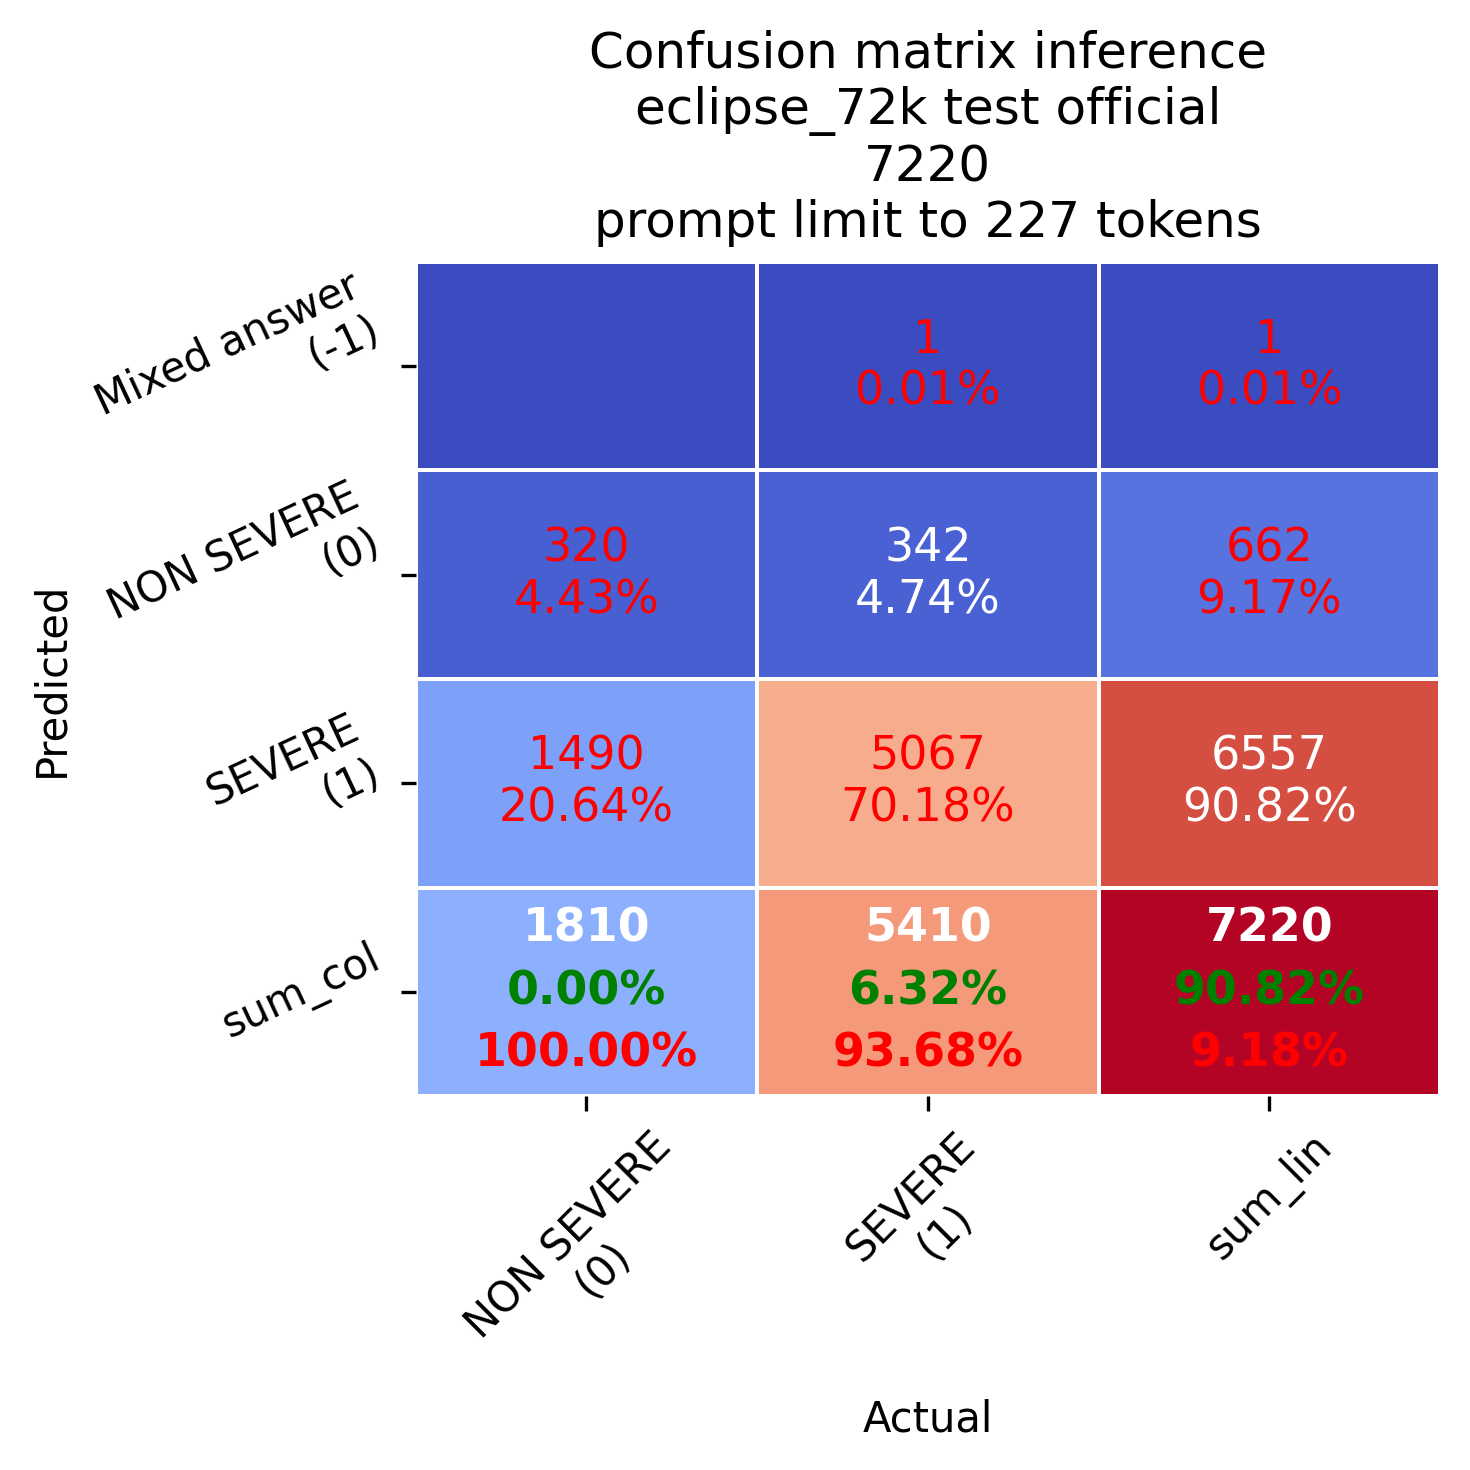

severity_pred dataset_type prompt_id dataset_choice dataset_type
72192              1           tr  official    eclipse_72k           tr
72193              1           tr  official    eclipse_72k           tr
72194              1           tr  official    eclipse_72k           tr
72196              1           tr  official    eclipse_72k           tr
72197              1           tr  official    eclipse_72k           tr

[[    2  2183 10479]
 [    1  2408 35461]]


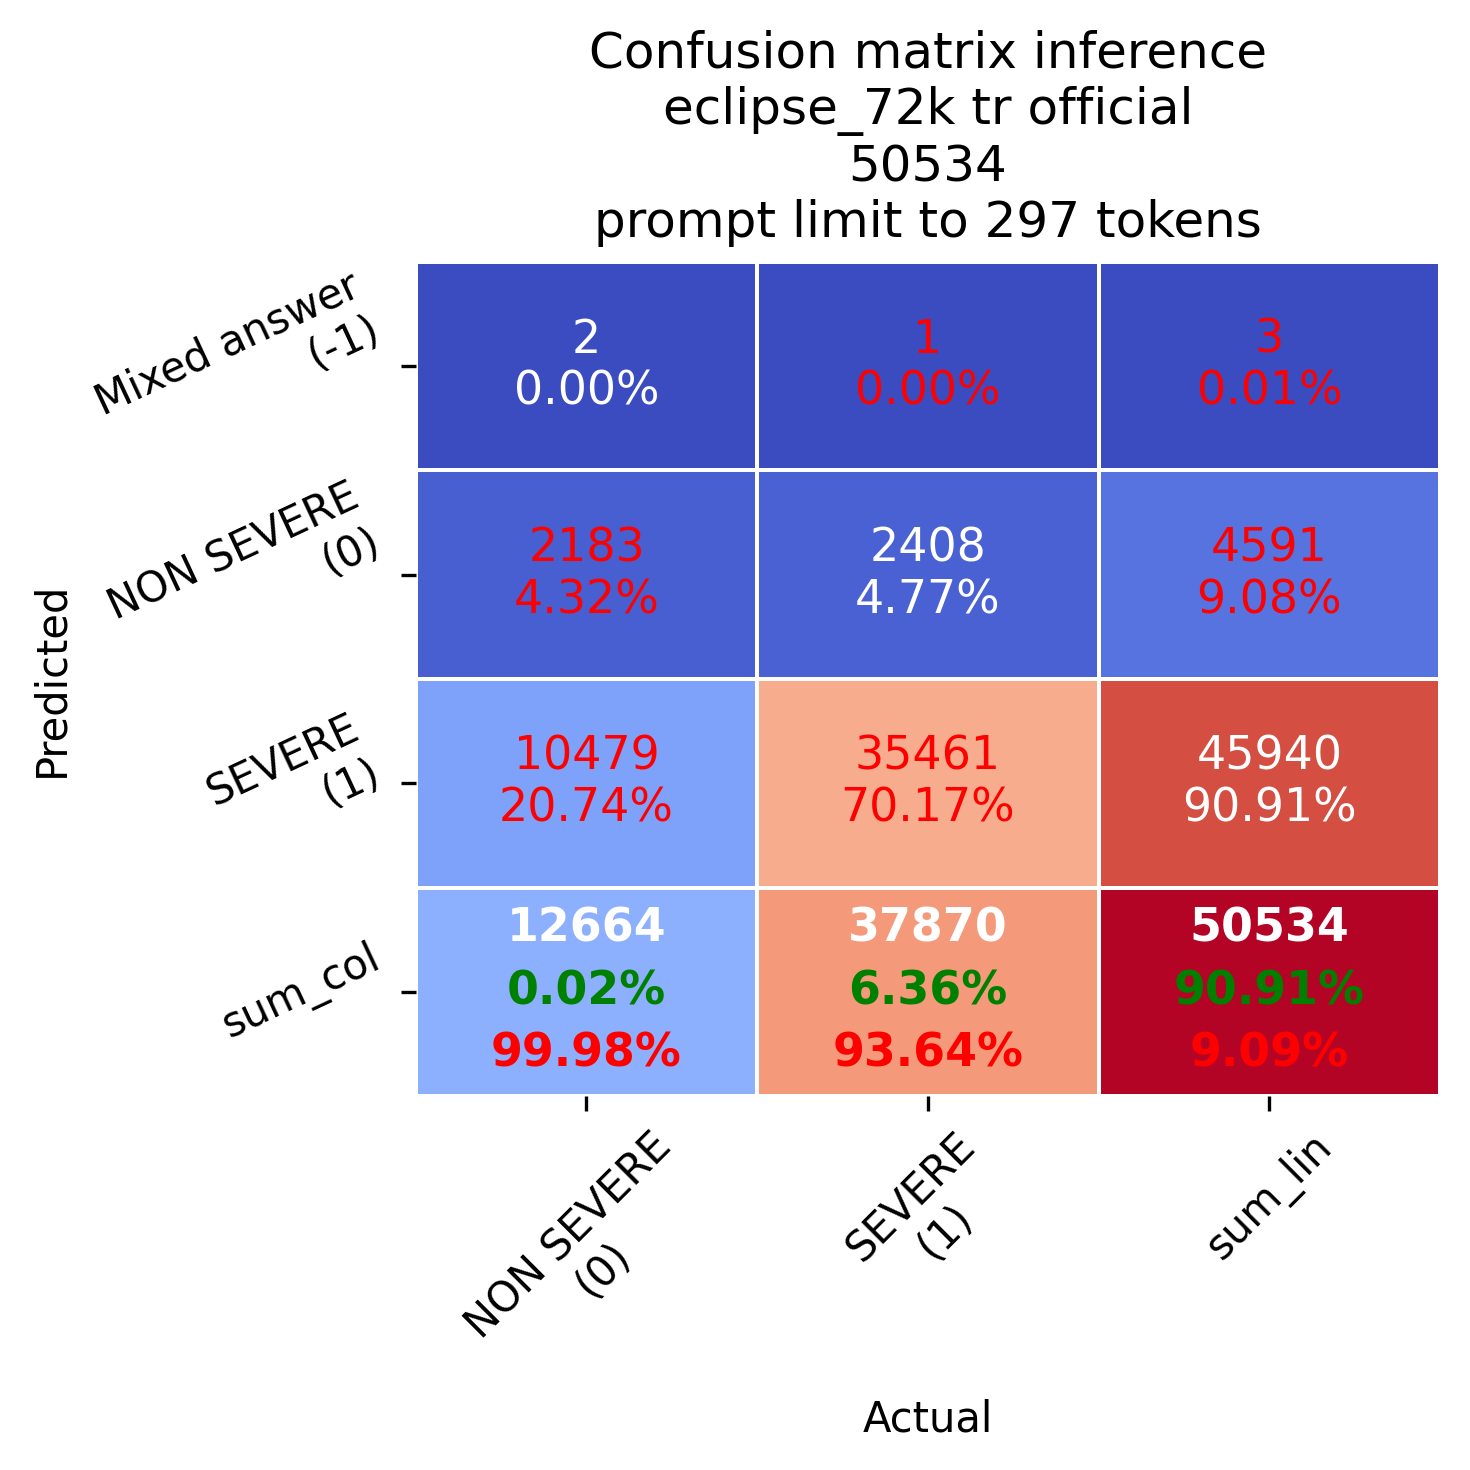

severity_pred dataset_type prompt_id dataset_choice dataset_type
72199              1          val  official    eclipse_72k          val
72214              1          val  official    eclipse_72k          val
72215              1          val  official    eclipse_72k          val
72223              1          val  official    eclipse_72k          val
72225              0          val  official    eclipse_72k          val

[[    0   583  3035]
 [    1   695 10124]]


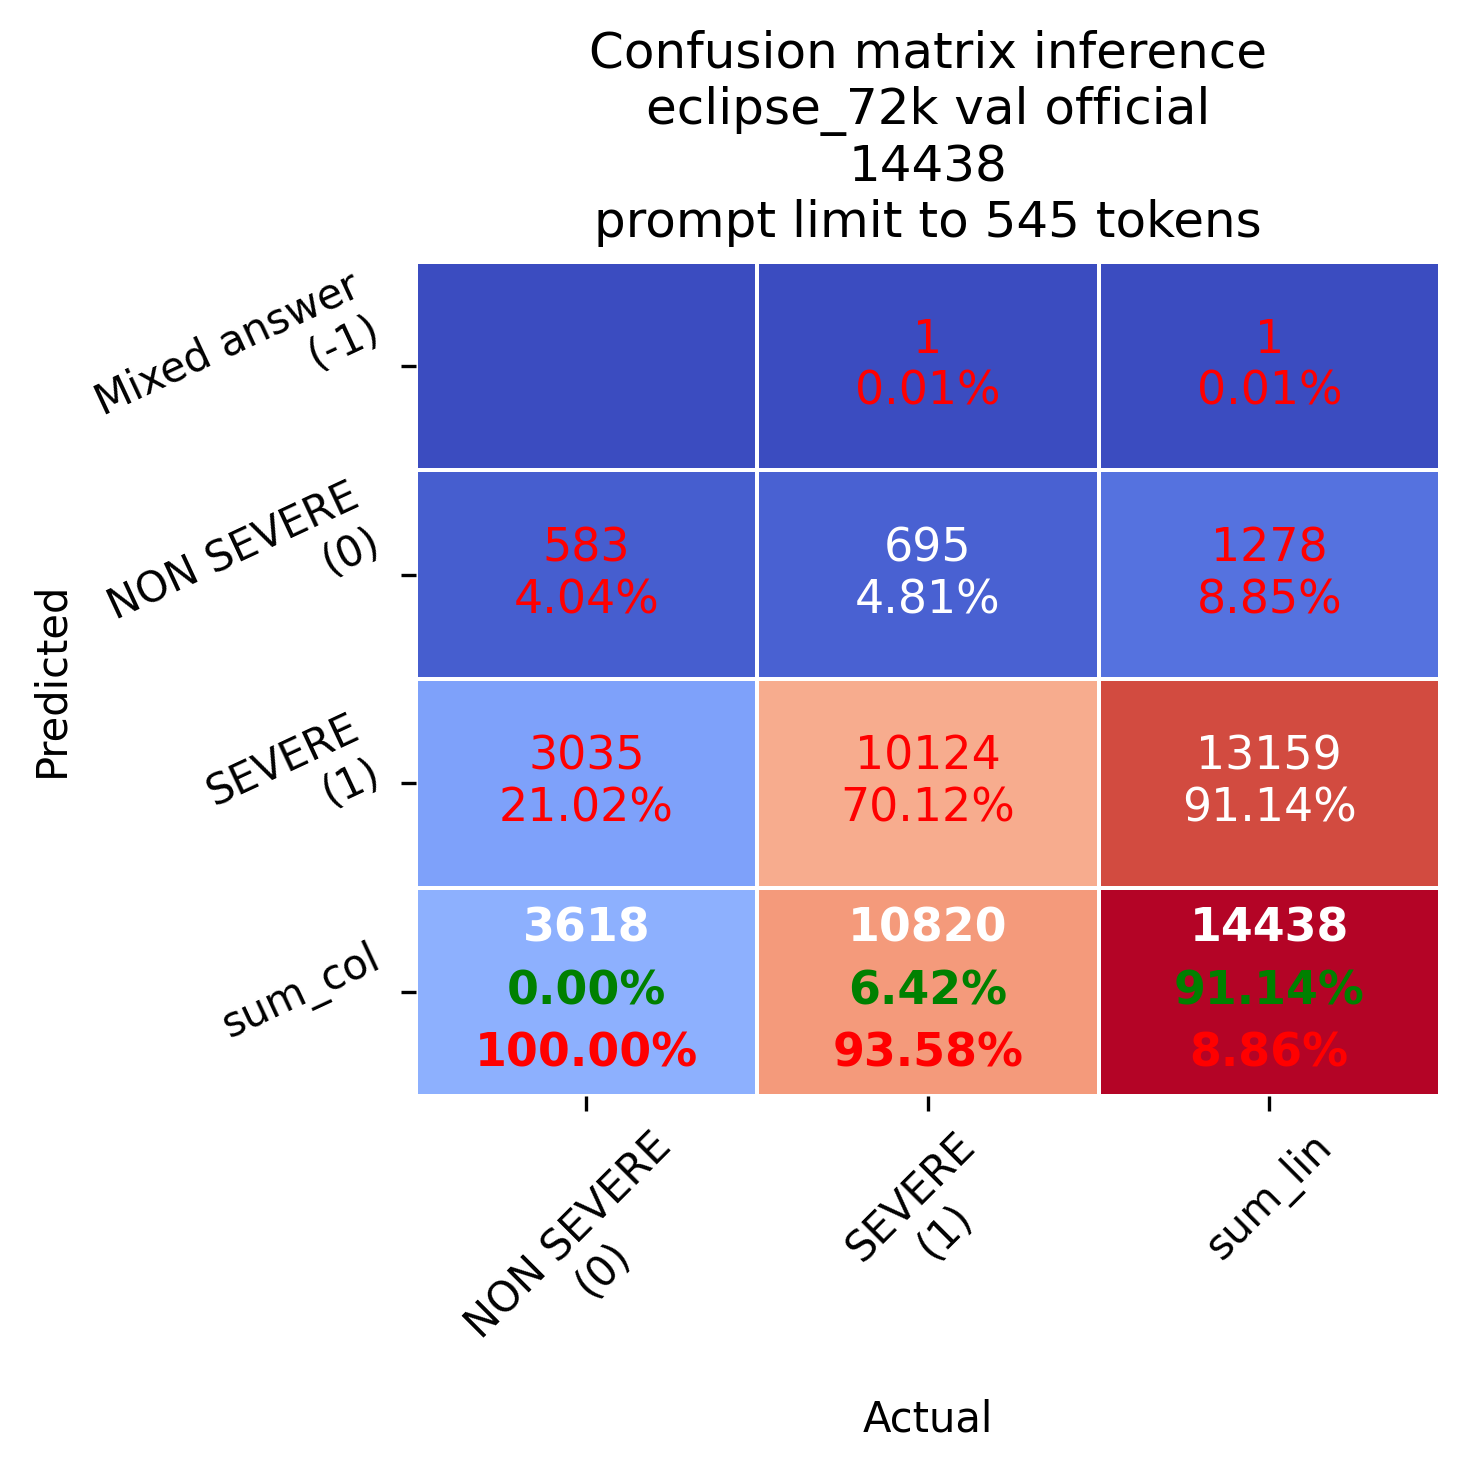

severity_pred dataset_type prompt_id dataset_choice dataset_type
472317              0         test  official   mozilla_200k         test
472339              1         test  official   mozilla_200k         test
472354              1         test  official   mozilla_200k         test
472360              1         test  official   mozilla_200k         test
472386              1         test  official   mozilla_200k         test

[[    0   480  4298]
 [    1   526 13120]]


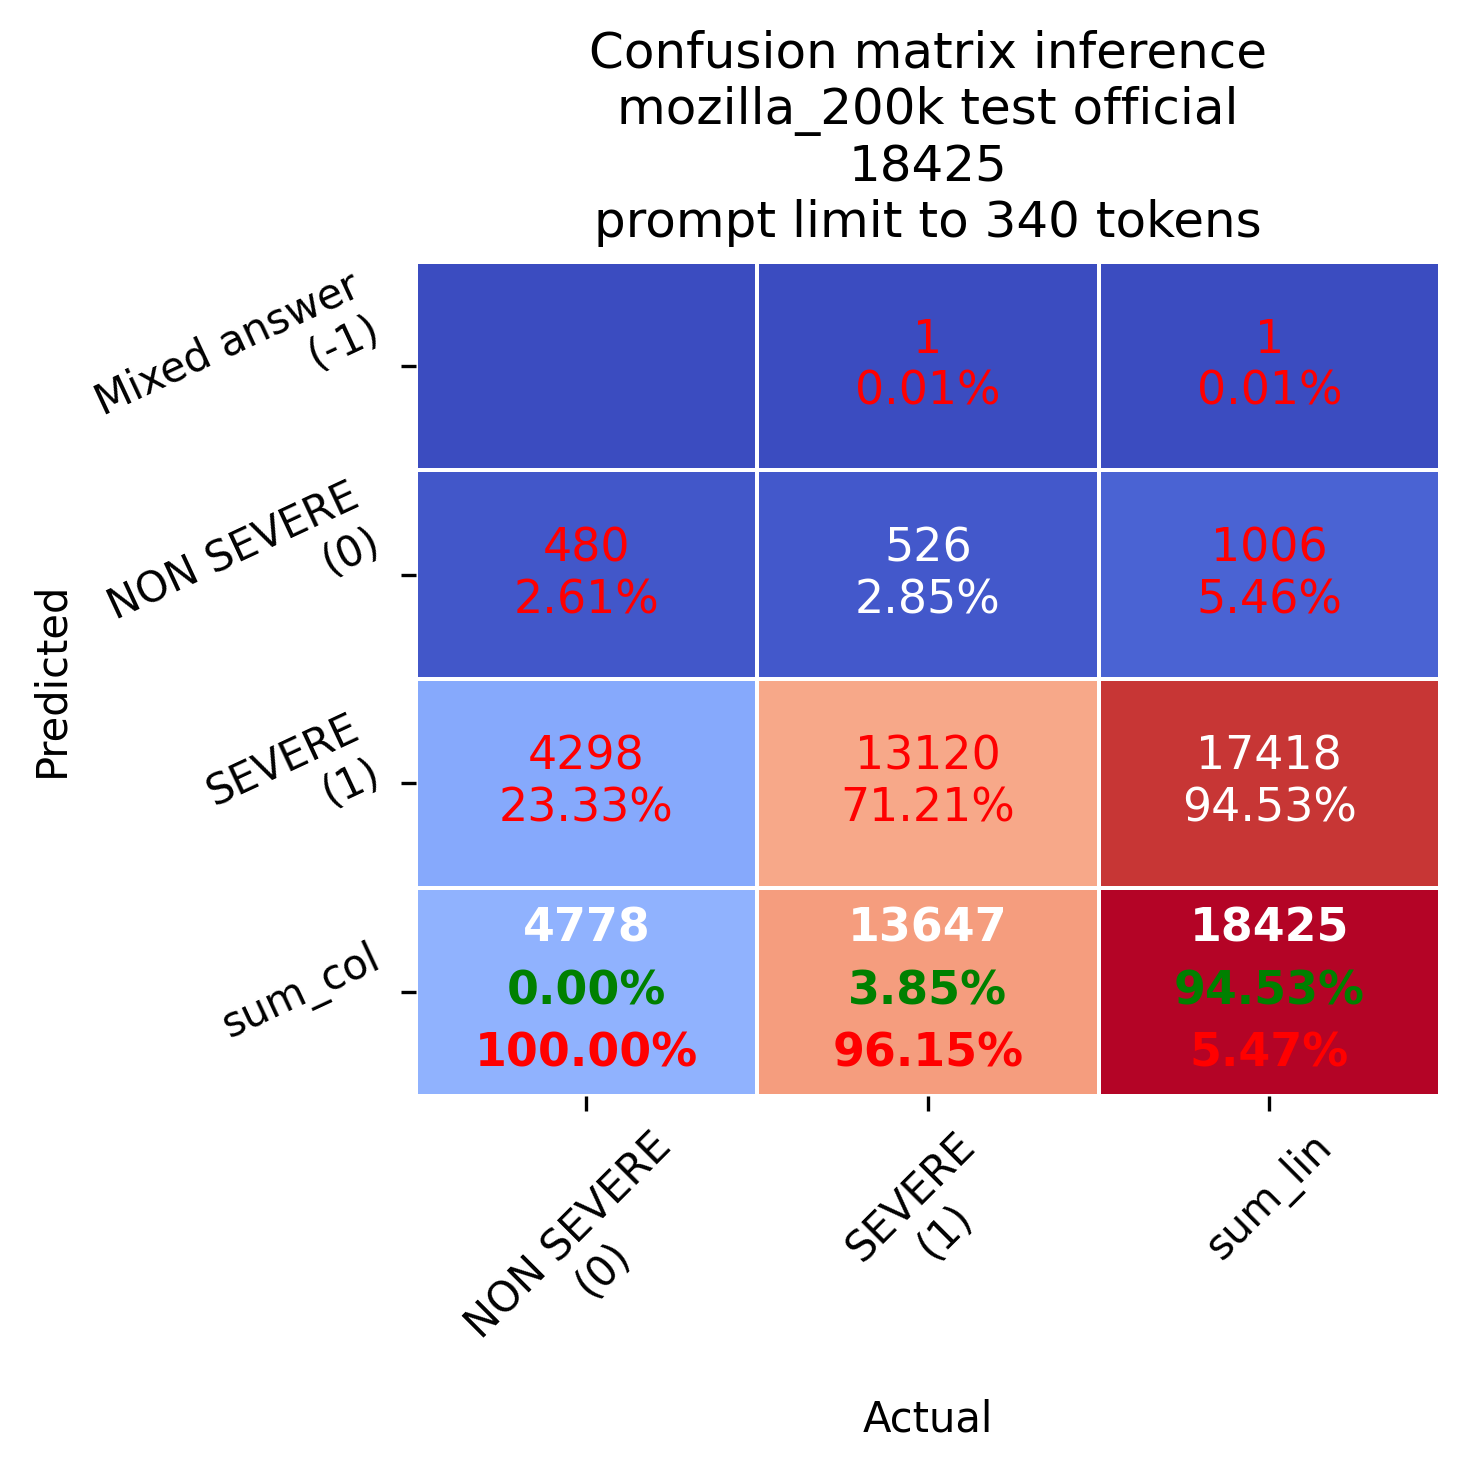

severity_pred dataset_type prompt_id dataset_choice dataset_type
472311              1           tr  official   mozilla_200k           tr
472312              1           tr  official   mozilla_200k           tr
472313              1           tr  official   mozilla_200k           tr
472315              1           tr  official   mozilla_200k           tr
472316              1           tr  official   mozilla_200k           tr

[[    0  3215 29946]
 [    5  3669 91603]]


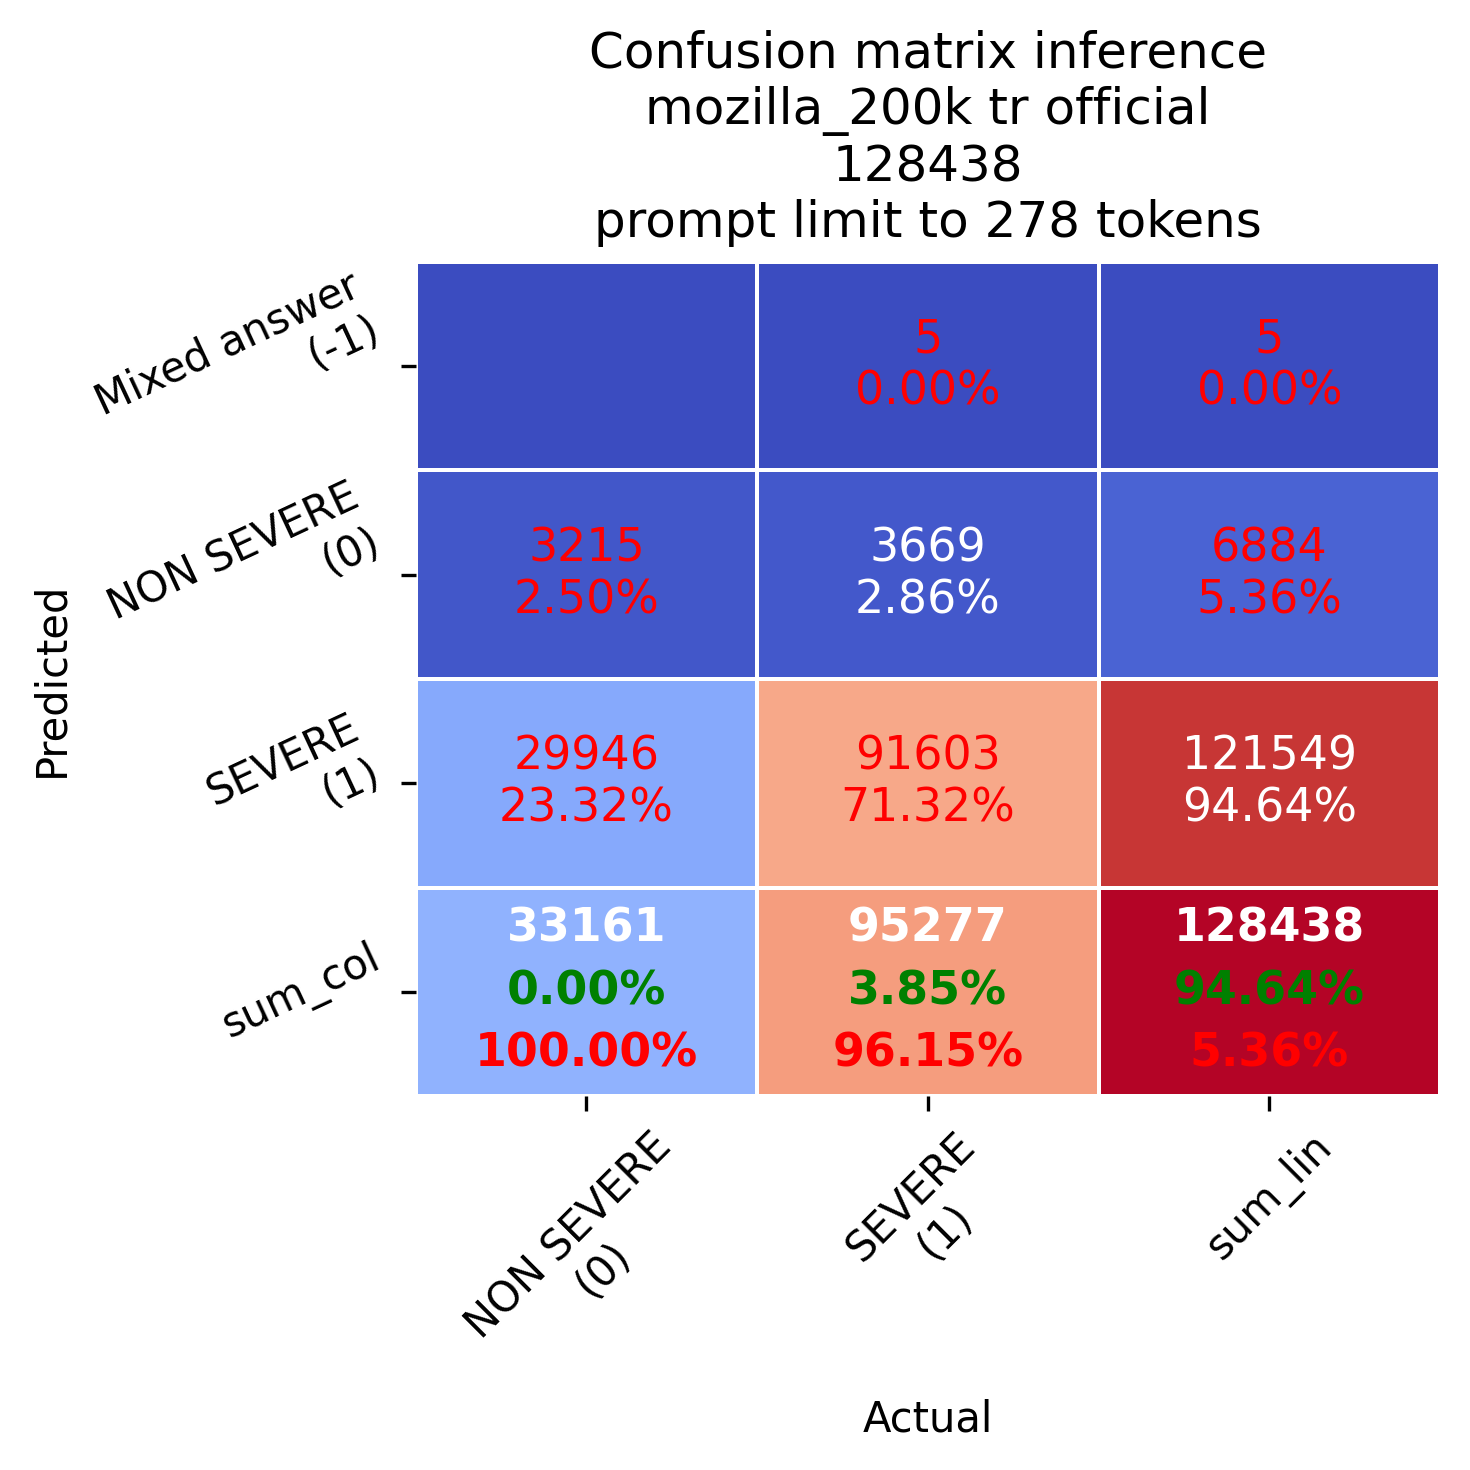

severity_pred dataset_type prompt_id dataset_choice dataset_type
472314              1          val  official   mozilla_200k          val
472320              1          val  official   mozilla_200k          val
472328              1          val  official   mozilla_200k          val
472329              1          val  official   mozilla_200k          val
472340              1          val  official   mozilla_200k          val

[[    1   932  8585]
 [    1  1021 26140]]


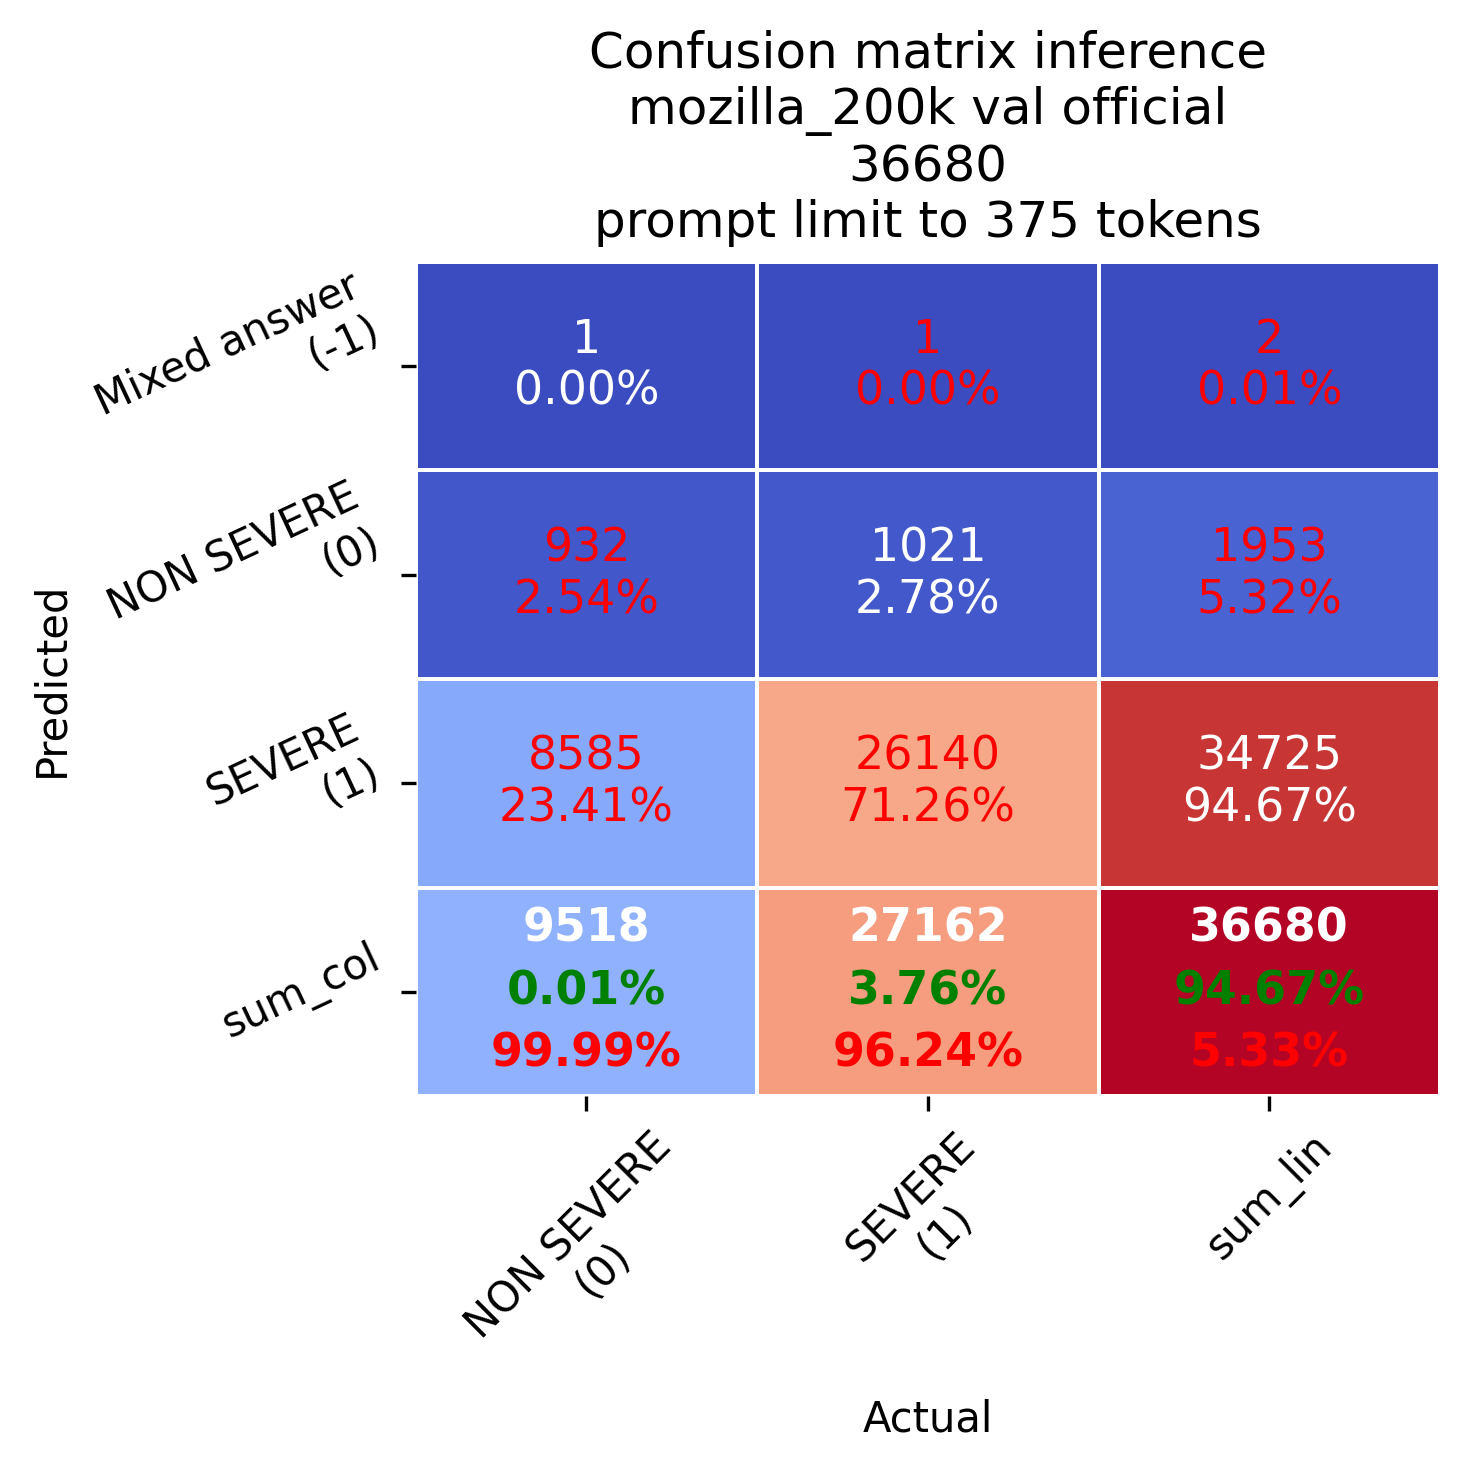

In [19]:
l = []
for (prompt_id, dataset_choice, dataset_type), group_data in groups:
    display(group_data.head()[['severity_pred','dataset_type',"prompt_id","dataset_choice","dataset_type"]])
    d = group_data.to_dict(orient="records")
    n_tokens_infered_max = d[0]['n_tokens']
    prompt_id = d[0]['prompt_id']
    confusion_matrix, f1, data_full = compute_metrics_from_list(d, pred_field="severity_pred",)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    df1 = pd.DataFrame(d)
    try:
        fpr, tpr, thresholds = roc_curve(y_true=np.array(df1['binary_severity']), y_score=np.array(df1['severity_pred']))
        roc_auc = auc(fpr, tpr)
        l.append({"n_elems": len(d), "n_tokens_infered_max": n_tokens_infered_max, "roc_auc":roc_auc, "dataset_choice": dataset_choice, "dataset_type":dataset_type,"confusion_matrix":confusion_matrix,"f1":f1,"accuracy":accuracy*100, **d[0]["parameters"]})
    except ValueError:
        display(df1[df1.isna()])
        raise Exception
    possibilities_pred = list(sorted(set(data_full["severity_pred"].unique())))
    print(confusion_matrix)
    plot_confusion(
        conf_matrix=np.array(confusion_matrix),
        folder_path=Path(f"../../data/{folder_name}/"),
        unique_values=possibilities_pred,
        id=f"{dataset_choice}_{dataset_type}_{n_tokens_infered_max}_prompt-{prompt_id}",
        title=f"Confusion matrix inference\n{dataset_choice} {dataset_type} {prompt_id}\n{len(data_full)}\nprompt limit to {n_tokens_infered_max} tokens",
        backend=None,
    )

In [10]:

for prompt_type in dfs:
    for i in range(len(dfs[prompt_type]['df'])):
        dataset_type = dfs[prompt_type]['df'].iloc[i].dataset_type
        dataset_choice = dfs[prompt_type]['df'].iloc[i].dataset_choice
        n_tokens_infered_max = dfs[prompt_type]['df'].iloc[i].n_tokens_infered_max
        data = dfs[prompt_type]['df'].iloc[i]
        data_full = dfs[prompt_type]['df_elems'].query(f"dataset_choice == '{dataset_choice}' & dataset_type == '{dataset_type}' & n_tokens_infered_max == {n_tokens_infered_max}")
        # display(data_full.query("binary_severity == 1"))
        all_bug_ids = set(pd.read_json(f"../../data/llm/{dataset_choice}.json")['bug_id'])
        missing = (all_bug_ids.difference(set(data_full['bug_id'])))
        # add the nan predictions
        d = data_full.query("severity_pred < -1")
        missing = list(missing.union(d['bug_id']))
        with open(f'../../data/{folder_name}/inference_{dataset_type}_prompt-{prompt_type}_missing.json', 'w') as fp:
            json.dump(missing,fp,indent=4)
        possibilities_pred = list(sorted(set(data_full["severity_pred"].unique())))
        print(data.confusion_matrix)
        compute_metrics_from_files(np.array(data.confusion_matrix),
                                f1=data.f1,
                                folder_out=Path(f"../../data/{folder_name}/"),
                                possibilities_pred=possibilities_pred,
                                id="_"+dataset_choice+"_"+dataset_type+"_"+str(n_tokens_infered_max)+f"_prompt-{prompt_type}",
                                title=f"Confusion matrix inference\n{dataset_type}\nprompt limit to {n_tokens_infered_max} tokens",
                                n_tokens_infered_max=n_tokens_infered_max,
                                data_full=data_full,
                                )


TypeError: object of type 'NoneType' has no len()

In [ ]:
df_oom = df_elems.query(f"dataset_type == 'mozilla_200k' & n_tokens_infered_max == 1000 & severity_pred == -2")
pd.set_option('display.max_colwidth', None)
display(df_oom.query("n_tokens <= 148")[['n_tokens','input']].sort_values("n_tokens"))
px.histogram(df_oom, x="n_tokens", title="n_tokens (template included) for mozilla_200k samples that yield oom")

n_tokens  \
221189       146   
224834       146   
233878       146   
216009       146   
226258       146   
...          ...   
221378       148   
221334       148   
221317       148   
221803       148   
241336       148   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         input  
221189                 Always answer with one token. Do not give any explanation. Use only 0 or 1 and one token. Skip any politeness answer. You have only one word available.\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Input: proxy\n\n\n### Remembering the instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Response:  
224834                   Always answer with one token. Do not give any explanation. Use only 0 or 1 and one token. Skip any politeness answer. You have only one word available.\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Input: run\n\n\n### Remembering the instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Response:  
233878               Always answer with one token. Do not give any explanation. Use only 0 or 1 and one token. Skip any politeness answer. You have only one word available.\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Input: crashes\n\n\n### Remembering the instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Response:  
216009               Always answer with one token. Do not give any explanation. Use only 0 or 1 and one token. Skip any politeness answer. You have only one word available.\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Input: Browser\n\n\n### Remembering the instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Response:  
226258               Always answer with one token. Do not give any explanation. Use only 0 or 1 and one token. Skip any politeness answer. You have only one word available.\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Input: windows\n\n\n### Remembering the instruction:\nCategorize the bug report into one of 2 categories:\n\n0 = NOT SEVERE\n1 = SEVERE\n\n### Response:  
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              